In [2]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.1', '1.2.1')

In [58]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Datasets & Dataloader

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [49]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(64),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)


test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [10]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [11]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Arsitekstur & Config

In [12]:
# manual
# nn.Conv2d(3, 8, 3, 1, 1)
# nn.Relu(),
# nn.MaxPool2d(2, 2)

In [14]:
from jcopdl.layers import conv_block, linear_block

In [37]:
class HamaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation='lsoftmax')
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [48]:
config = set_config({
    "batch_size" : bs,
    "crop_size" : crop_size
})

# Training Preparation -> MCOC

In [53]:
model = HamaClassifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(params=model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [41]:
from tqdm.auto import tqdm
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature) # feedforward
        loss = criterion(output, target)
        if mode == "train":
            loss.backward() # backpropragation
            optimizer.step() # update weight
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6955 | Test_cost  = 0.6916 | Train_score = 0.4980 | Test_score = 0.7675 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6891 | Test_cost  = 0.6790 | Train_score = 0.5890 | Test_score = 0.6725 |
==> EarlyStop patience =  1 | Best test_score: 0.7675


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6634 | Test_cost  = 0.6171 | Train_score = 0.6240 | Test_score = 0.6375 |
==> EarlyStop patience =  2 | Best test_score: 0.7675


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5759 | Test_cost  = 0.5658 | Train_score = 0.7200 | Test_score = 0.7250 |
==> EarlyStop patience =  3 | Best test_score: 0.7675


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5198 | Test_cost  = 0.4775 | Train_score = 0.7620 | Test_score = 0.7650 |
==> EarlyStop patience =  4 | Best test_score: 0.7675


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.4484 | Test_cost  = 0.4264 | Train_score = 0.7970 | Test_score = 0.8025 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4503 | Test_cost  = 0.4605 | Train_score = 0.7960 | Test_score = 0.7875 |
==> EarlyStop patience =  1 | Best test_score: 0.8025


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4695 | Test_cost  = 0.3963 | Train_score = 0.7710 | Test_score = 0.8250 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4505 | Test_cost  = 0.4018 | Train_score = 0.7780 | Test_score = 0.8250 |
==> EarlyStop patience =  1 | Best test_score: 0.8250


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4156 | Test_cost  = 0.4027 | Train_score = 0.8050 | Test_score = 0.8100 |
==> EarlyStop patience =  2 | Best test_score: 0.8250


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.3944 | Test_cost  = 0.3832 | Train_score = 0.8300 | Test_score = 0.8175 |
==> EarlyStop patience =  3 | Best test_score: 0.8250


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.3934 | Test_cost  = 0.3604 | Train_score = 0.8240 | Test_score = 0.8550 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.3877 | Test_cost  = 0.3564 | Train_score = 0.8320 | Test_score = 0.8575 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3659 | Test_cost  = 0.3488 | Train_score = 0.8410 | Test_score = 0.8500 |
==> EarlyStop patience =  1 | Best test_score: 0.8575


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3932 | Test_cost  = 0.3430 | Train_score = 0.8190 | Test_score = 0.8600 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.4212 | Test_cost  = 0.3778 | Train_score = 0.8100 | Test_score = 0.8400 |
==> EarlyStop patience =  1 | Best test_score: 0.8600


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.4011 | Test_cost  = 0.3591 | Train_score = 0.8090 | Test_score = 0.8475 |
==> EarlyStop patience =  2 | Best test_score: 0.8600


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3825 | Test_cost  = 0.3352 | Train_score = 0.8350 | Test_score = 0.8600 |
==> EarlyStop patience =  3 | Best test_score: 0.8600


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3609 | Test_cost  = 0.3349 | Train_score = 0.8420 | Test_score = 0.8525 |
==> EarlyStop patience =  4 | Best test_score: 0.8600


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.3668 | Test_cost  = 0.3288 | Train_score = 0.8400 | Test_score = 0.8575 |


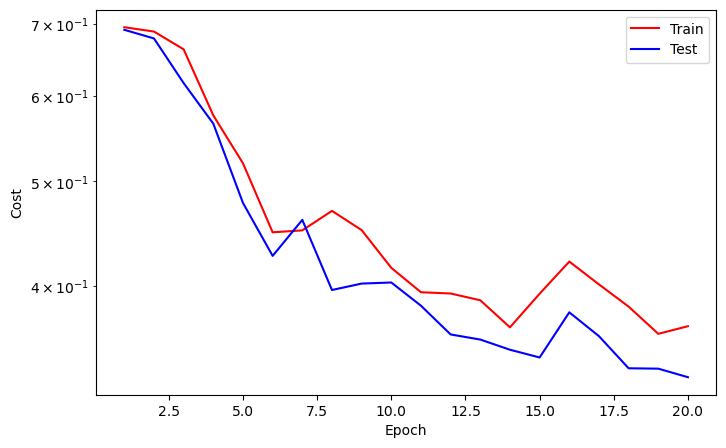

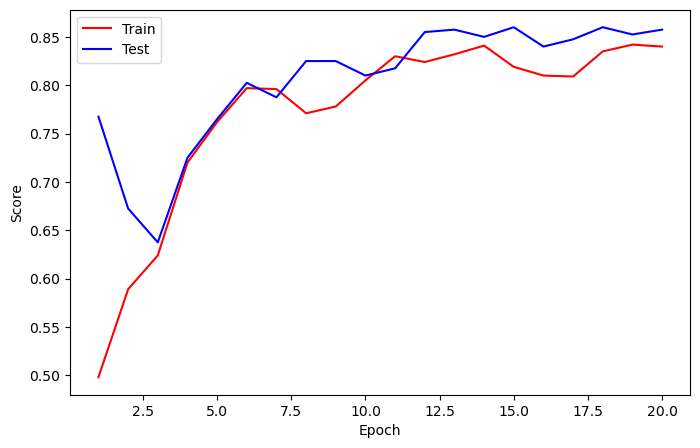

==> EarlyStop patience =  5 | Best test_score: 0.8600
==> Execute Early Stopping at epoch: 20 | Best test_score: 0.8600
==> Best model is saved at model


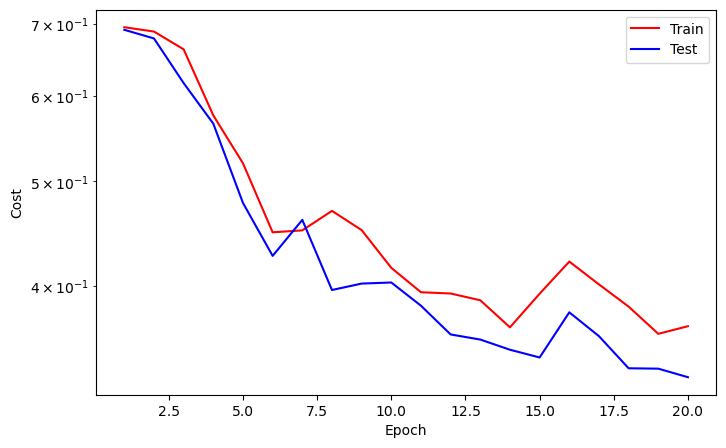

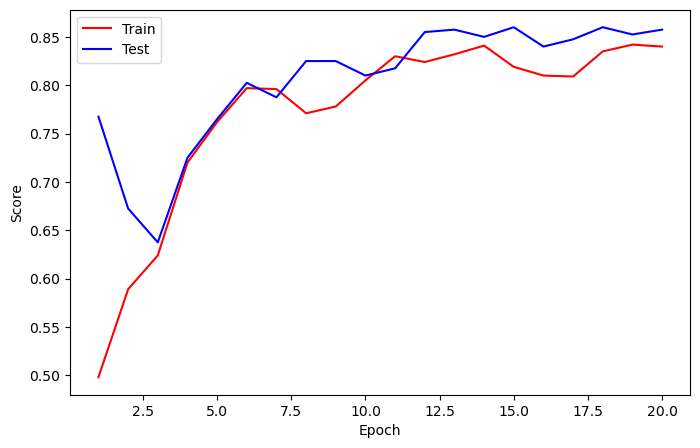

In [54]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    # Save CheckPoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict

In [55]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [56]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')

# Visualization

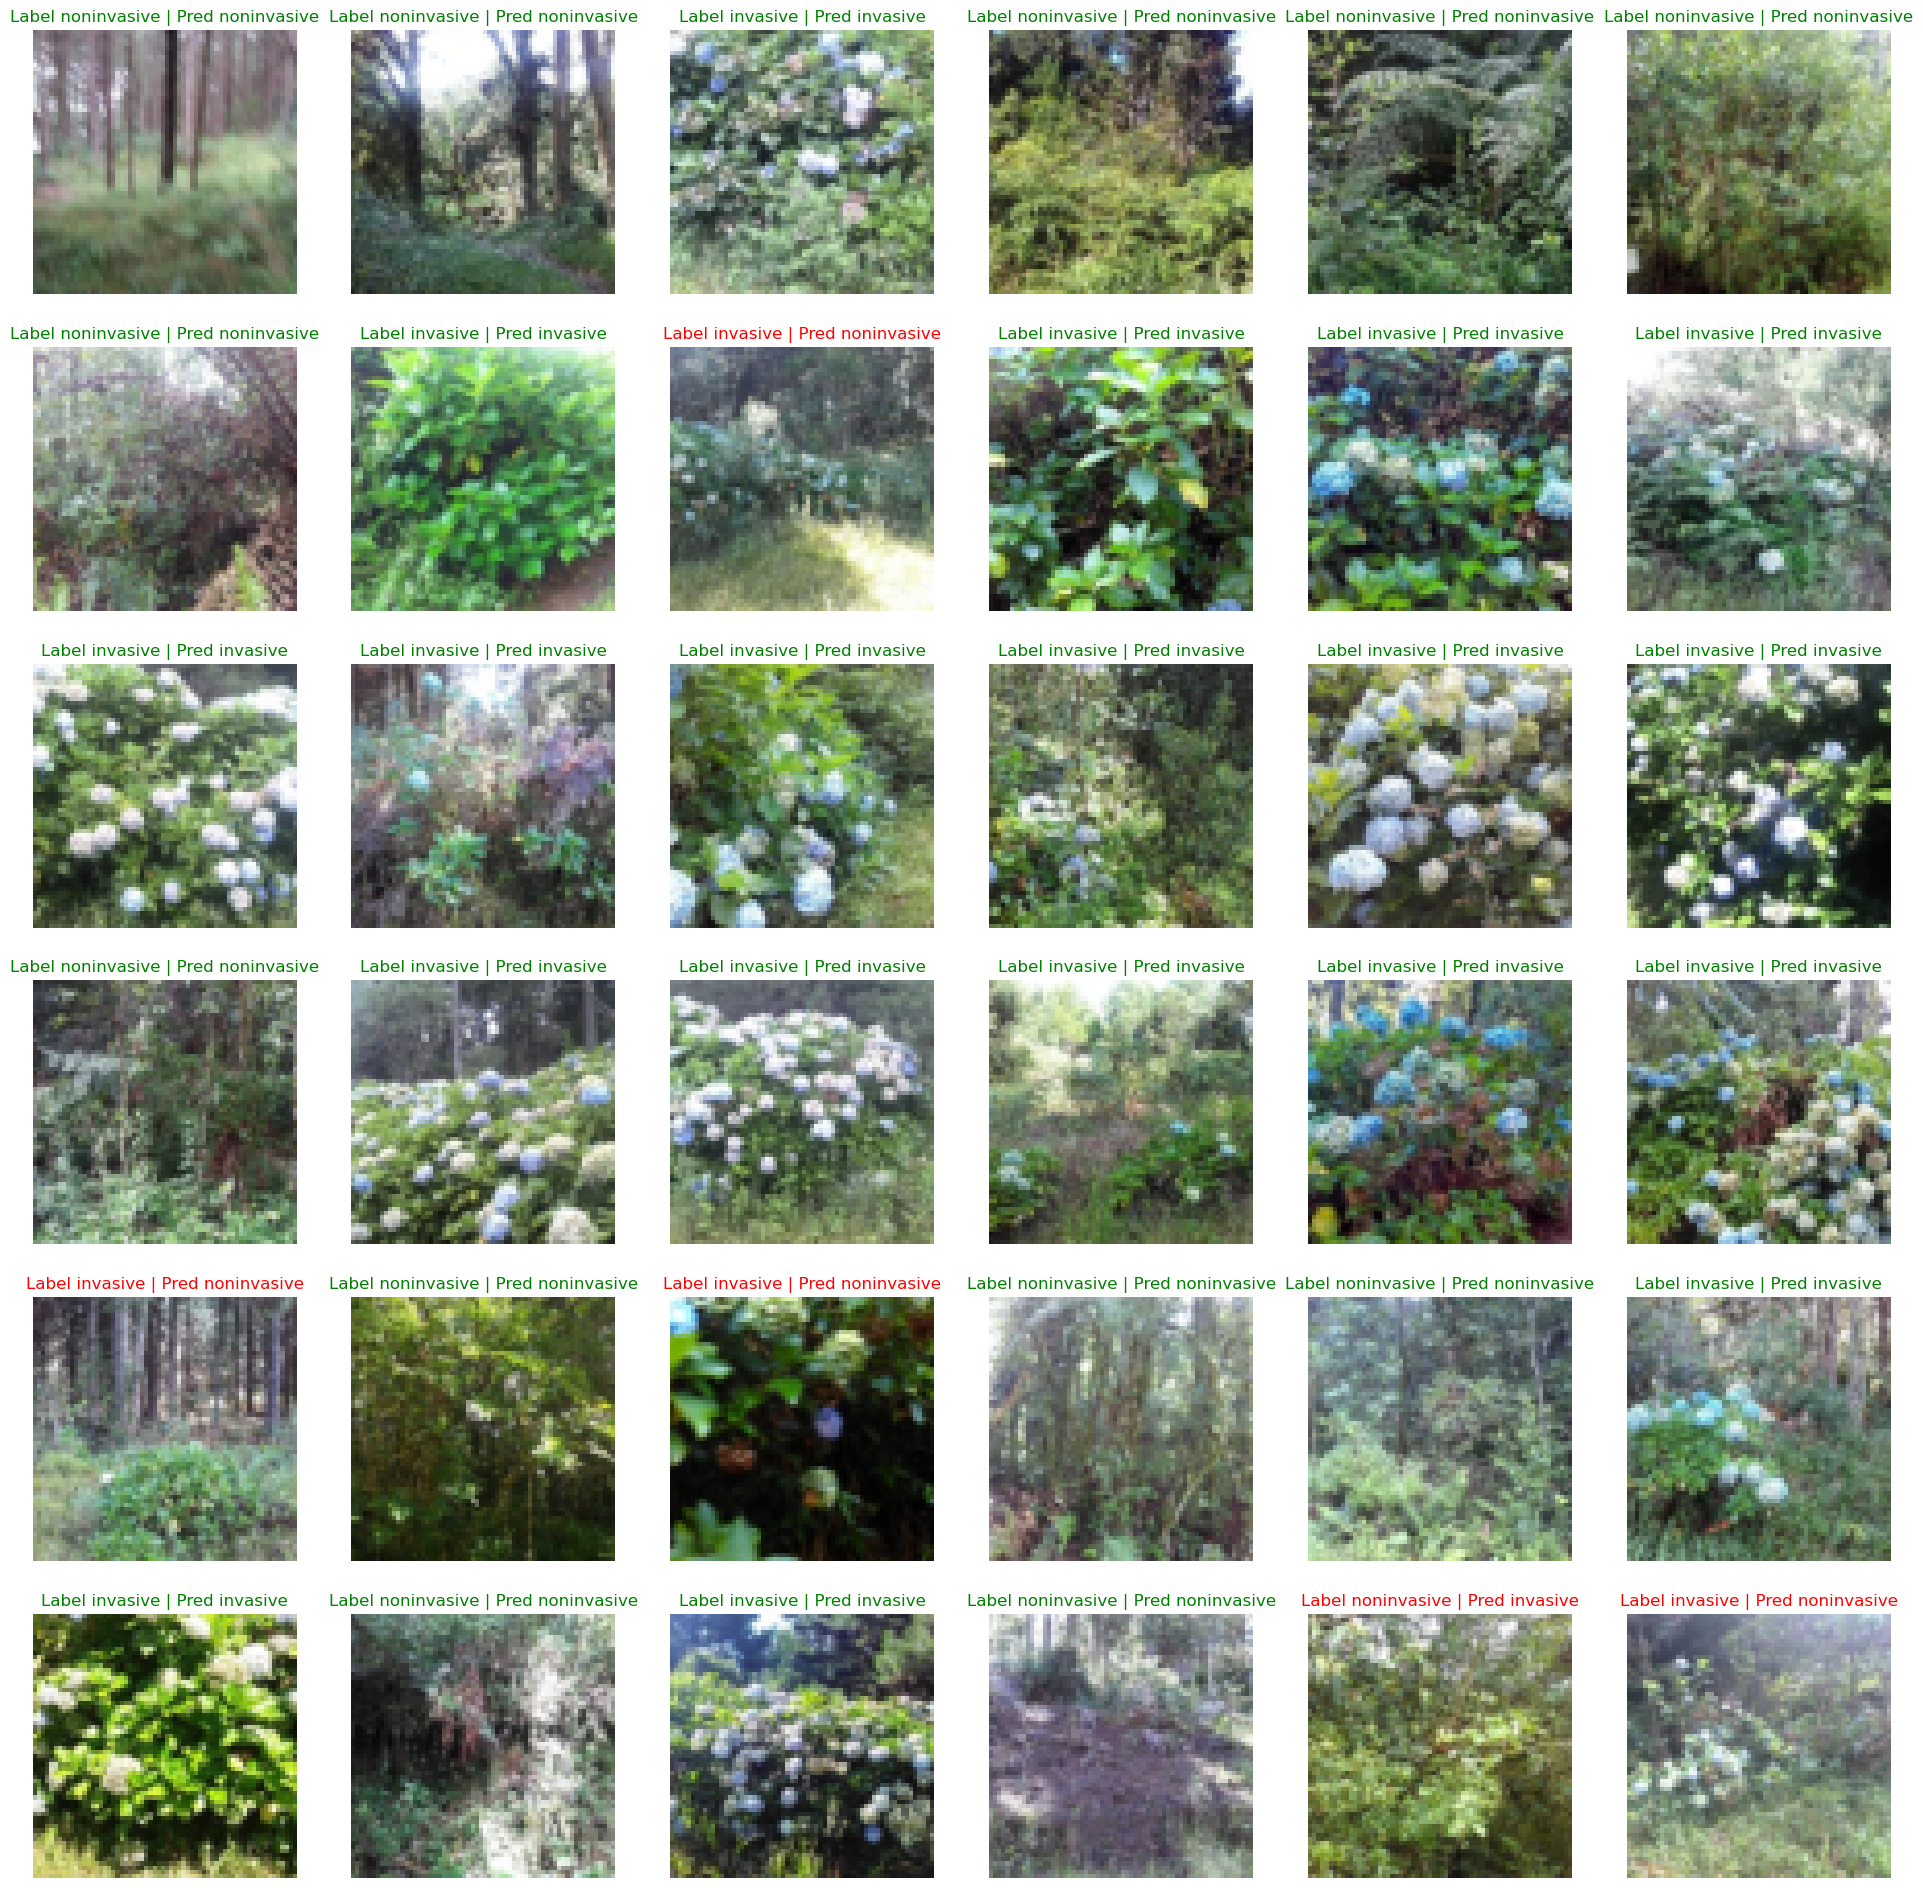

In [60]:
fig, axes = plt.subplots(6, 6, figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color" : "r" if label != pred else "g"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label {label} | Pred {pred}", fontdict=font)
    ax.axis('off')